## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

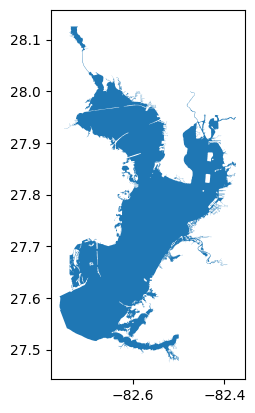

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(16229, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/clean.py:356: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  cond_notna = mask & (df_out["QA_flag"].notna())  # Mask cond and not NA
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/clean.py:360: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(16229, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

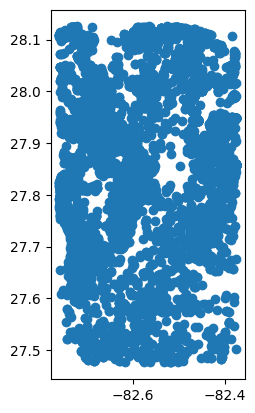

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

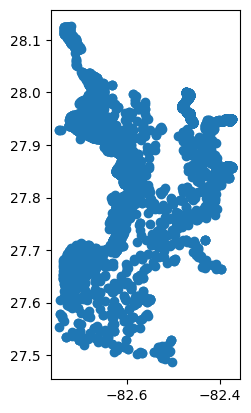

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10720

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,33,36,38,58,60,61,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506055,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1506056,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1506057,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1506058,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

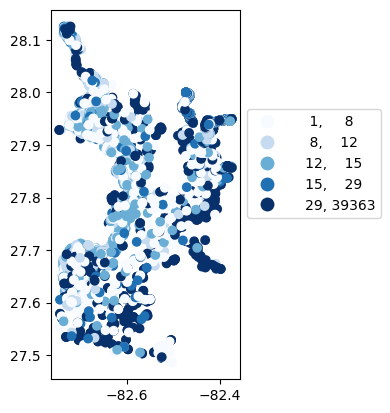

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ResultMeasureValue: "Not Reported" result cannot be used' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.8, 'meter')> <Quantity(2.2, 'meter')>
 <Quantity(2.7, 'meter')> ... <Quantity(2.3, 'meter')>
 <Quantity(1.4, 'meter')> <Quantity(1.6, 'meter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    89839.000000
mean         1.472997
std          0.909449
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 243
Usable results with inferred units: 1
Results outside threshold (0.0 to 6.9296919743043714): 55


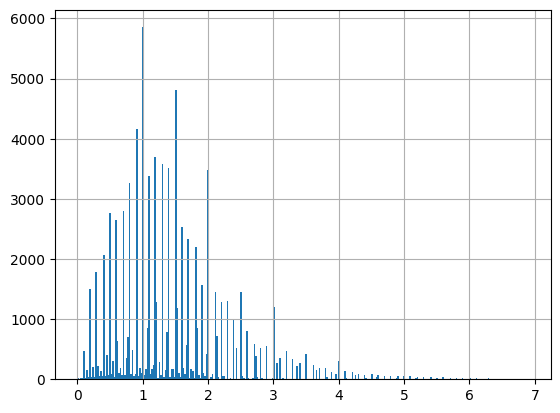

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
36,21FLHILL_WQX-1510,0.80,m,NaN,m,0.8 meter
68,21FLMANA_WQX-428,2.2,m,NaN,m,2.2 meter
96,21FLHILL_WQX-096,2.70,m,NaN,m,2.7 meter
106,21FLHILL_WQX-064,0.80,m,NaN,m,0.8 meter
127,21FLCOSP_WQX-COSPE6-2,1.7,m,NaN,m,1.7 meter
...,...,...,...,...,...,...
1505129,21FLBSG-13,1.4,m,NaN,m,1.4 meter
1505130,21FLBSG-13,1.6,m,NaN,m,1.6 meter
1505131,21FLBSG-13,2.3,m,NaN,m,2.3 meter
1505141,21FLBSG-13,1.4,m,NaN,m,1.4 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
558577,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
563463,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
566782,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
568709,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
570188,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1496665,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1496718,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1496721,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1497007,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
284818,NARS_WQX-NCCA10-1674,-9,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",m,-9.0 meter
558577,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
563463,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
566782,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
568709,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1496665,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1496718,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1496721,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1497007,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
11835,USGS-280630082350900,3,1.966667
11836,USGS-280635082322100,2,2.100000
11837,USGS-280640082434700,3,2.302933
11838,USGS-280719082291400,2,1.000000


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


<Axes: >

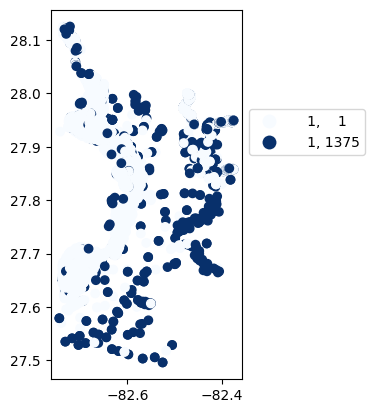

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

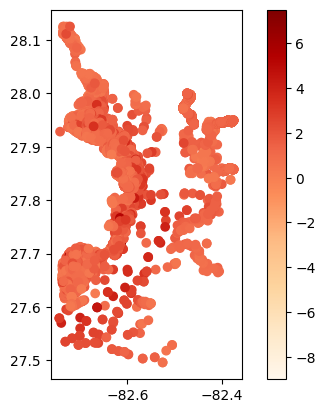

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(28.19, 'degree_Celsius')> <Quantity(29.52, 'degree_Celsius')>
 <Quantity(21.0, 'degree_Celsius')> ... <Quantity(25.0, 'degree_Celsius')>
 <Quantity(25.7, 'degree_Celsius')> <Quantity(26.1, 'degree_Celsius')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    307427.000000
mean         25.295733
std          78.937252
min          -2.900000
25%          21.220000
50%          25.880000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 166
Usable results with inferred units: 0
Results outside threshold (0.0 to 498.9192447548339): 2


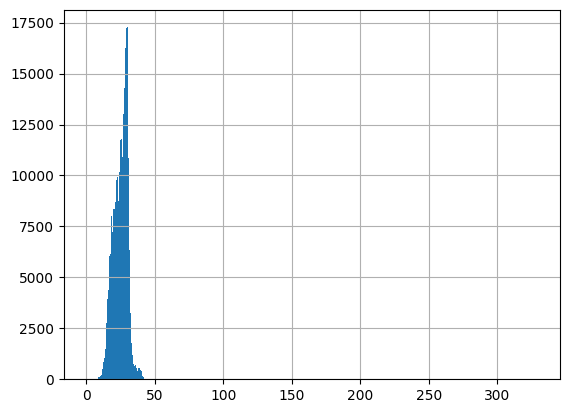

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
9,21FLTBW_WQX-M23,29.52,deg C,NaN,29.52 degree_Celsius,degC
14,21FLMANA_WQX-GA1,21,deg C,NaN,21.0 degree_Celsius,degC
34,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
37,21FLTBW_WQX-PR103026,17.73,deg C,NaN,17.73 degree_Celsius,degC
...,...,...,...,...,...,...
1506044,USGS-273217082335701,28.9,deg C,NaN,28.9 degree_Celsius,degC
1506047,USGS-274322082245501,24.4,deg C,NaN,24.4 degree_Celsius,degC
1506052,USGS-274302082280801,25.0,deg C,NaN,25.0 degree_Celsius,degC
1506055,USGS-273926082304501,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
562705,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
563790,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
565223,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
570271,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
576357,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
893011,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
896703,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1398110,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1490432,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
562705,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
563790,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
565223,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
570271,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
576357,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1398110,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1446888,21FLPDEM_WQX-24-01,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1447320,21FLPDEM_WQX-04-04,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1490432,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
15037,USGS-280726082313300,4,28.025000
15038,USGS-280728082301101,54,25.083333
15039,USGS-280729082313501,1,27.400000
15040,USGS-280730082313201,1,24.700000


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

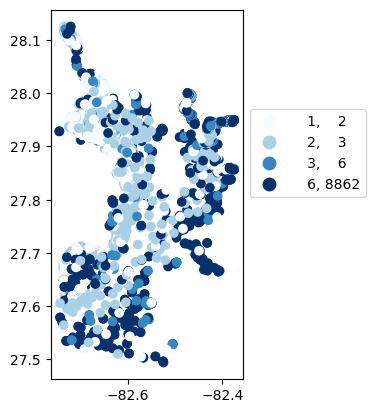

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

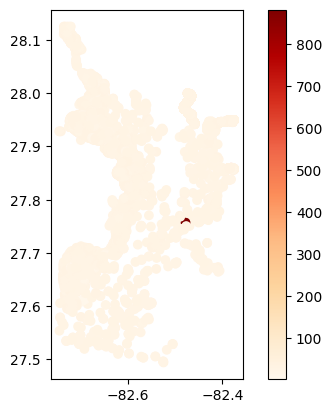

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(9.32, 'milligram / liter')>
 <Quantity(8.08, 'milligram / liter')>
 <Quantity(4.9, 'milligram / liter')> ...
 <Quantity(8.2, 'milligram / liter')> <Quantity(7.9, 'milligram / liter')>
 <Quantity(10.4, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1505410,21FLBSG-13,8.3,mg/l,NaN,8.3 milligram / liter
1505411,21FLBSG-13,12.4,mg/l,NaN,12.4 milligram / liter
1505412,21FLBSG-13,8.2,mg/l,NaN,8.2 milligram / liter
1505413,21FLBSG-13,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1458436,21FLHILL_WQX-61,8.02,mg/L,NaN,8.02 milligram / liter
1458439,21FLHILL_WQX-14,6.43,mg/L,NaN,6.43 milligram / liter
1458440,21FLHILL_WQX-71,7.76,mg/L,NaN,7.76 milligram / liter
1458455,21FLHILL_WQX-264,5.73,mg/L,NaN,5.73 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
13610,NARS_WQX-NCCA10-1672,8,5.437500
13611,NARS_WQX-NCCA10-1673,20,4.115000
13612,NARS_WQX-NCCA10-1674,6,2.466667
13613,NARS_WQX-NLA06608-0161,5,6.500000


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

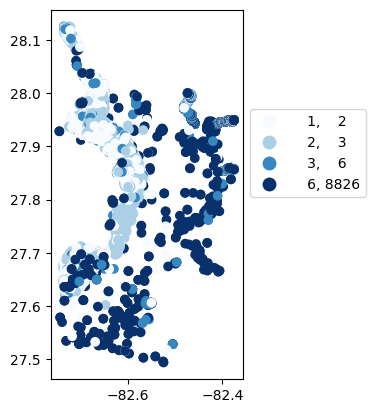

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

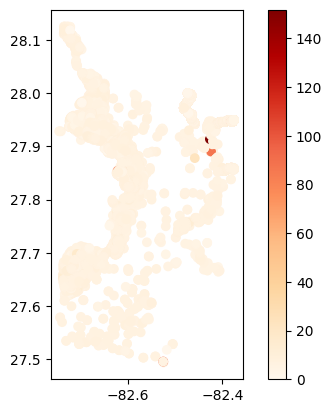

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.48, 'dimensionless')> <Quantity(8.18, 'dimensionless')>
 <Quantity(7.81, 'dimensionless')> ... <Quantity(7.8, 'dimensionless')>
 <Quantity(7.7, 'dimensionless')> <Quantity(7.6, 'dimensionless')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    283752.000000
mean          7.761578
std           0.472613
min           0.370000
25%           7.520000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 186
Usable results with inferred units: 265233
Results outside threshold (0.0 to 10.597255041665539): 7


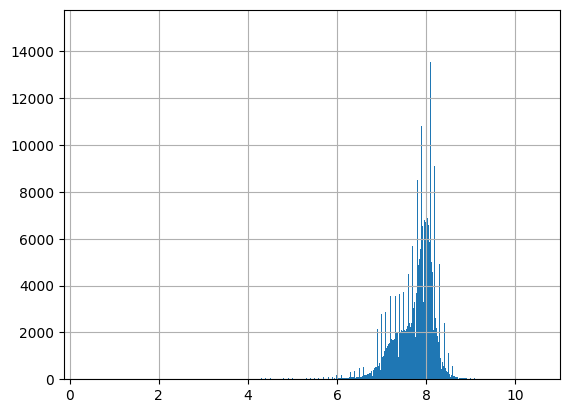

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.48 dimensionless
5,8.18,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.18 dimensionless
6,7.81,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.81 dimensionless
11,7.96,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.96 dimensionless
17,7.92,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.92 dimensionless
...,...,...,...,...
1506053,7.9,std units,NaN,7.9 dimensionless
1506054,7.3,std units,NaN,7.3 dimensionless
1506056,7.8,std units,NaN,7.8 dimensionless
1506057,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '@25C' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:510: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df[c_mask] = basis.update_result_basis(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(40.0, 'Practical_Salinity_Units')>
 <Quantity(29.0, 'Practical_Salinity_Units')>
 <Quantity(26.04, 'Practical_Salinity_Units')> ...
 <Quantity(27.3, 'Practical_Salinity_Units')>
 <Quantity(23.2, 'Practical_Salinity_Units')>
 <Quantity(25.6, 'Practical_Salinity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    274512.000000
mean         21.677561
std          94.088954
min          -0.020000
25%          17.970000
50%          24.900000
75%          28.690000
max       48930.000000
dtype: float64
Unusable results: 1265
Usable results with inferred units: 0
Results outside threshold (0.0 to 586.2112868673343): 4


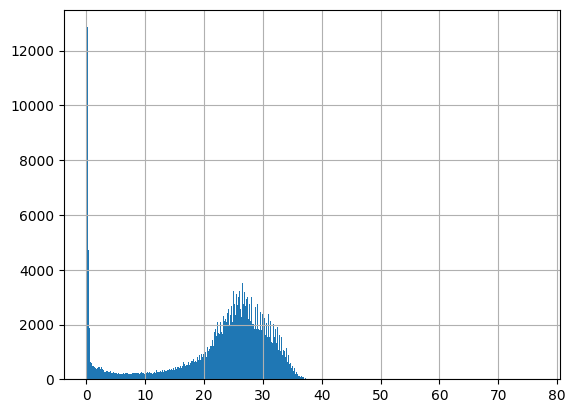

In [48]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
7,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
22,0.18,ppth,NaN,0.18 Practical_Salinity_Units
24,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1505389,25.0,PSS,NaN,25.0 Practical_Salinity_Units
1505391,22.8,PSS,NaN,22.8 Practical_Salinity_Units
1505392,27.3,PSS,NaN,27.3 Practical_Salinity_Units
1505393,23.2,PSS,NaN,23.2 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'as N' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:484: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 'as N'
 nan nan nan 'as N' nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan 'as N' nan 'as N' nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 'as N' nan nan nan nan
 'as N' nan 'as N' 'as N' nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitl

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.39, 'milligram / liter')>
 <Quantity(0.4475, 'milligram / liter')>
 <Quantity(0.425, 'milligram / liter')>
 <Quantity(0.4625, 'milligram / liter')>
 <Quantity(0.33625, 'milligram / liter')>
 <Quantity(0.28, 'milligram / liter')>
 <Quantity(0.5625, 'milligram / liter')>
 <Quantity(0.21875, 'milligram / liter')>
 <Quantity(0.629, 'milligram / liter')>
 <Quantity(0.505, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.325, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.456, 'milligram / liter')>
 <Quantity(0.183, 'milligram / liter')>
 <Quantity(0.526, 'milligram / liter')>
 <Quantity(0.264, 'milligram / liter')>
 <Quantity(0.188, 'milligram / liter')>
 <Quantity(0.346, 'milligram / liter')>
 <Quanti

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting objec

-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


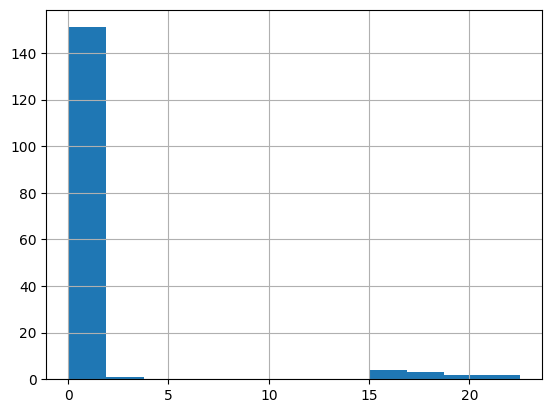

In [50]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
262029,0.39,mg/L,NaN,0.39 milligram / liter
278162,0.4475,mg/L,NaN,0.4475 milligram / liter
280955,0.425,mg/L,NaN,0.425 milligram / liter
294787,0.4625,mg/L,NaN,0.4625 milligram / liter
296176,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1505424,0.084,mg/l,NaN,0.084 milligram / liter
1505432,0.166,mg/l,NaN,0.166 milligram / liter
1505442,0.091,mg/l,NaN,0.091 milligram / liter
1505476,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(626.0, 'microsiemens / centimeter')>
 <Quantity(688.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(633.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(20500.0, 'microsiemens / centimeter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count       11.000000
mean      2503.363636
std       5969.279978
min        606.000000
25%        629.500000
50%        775.000000
75%        776.000000
max      20500.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 38319.04350375742): 0


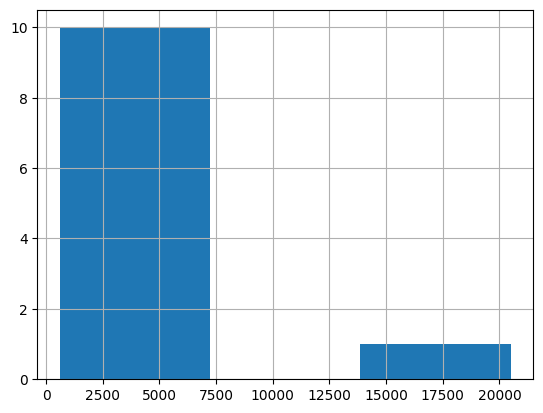

In [52]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
326137,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
330828,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
332265,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
334703,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
335567,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
337357,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
342039,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
358182,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
420532,626,uS/cm,NaN,626.0 microsiemens / centimeter
424898,688,uS/cm,NaN,688.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.00594, 'milligram / liter')>
 <Quantity(0.00145, 'milligram / liter')>
 <Quantity(0.00277, 'milligram / liter')> ...
 <Quantity(0.01098, 'milligram / liter')>
 <Quantity(0.03027, 'milligram / liter')>
 <Quantity(0.02559, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    43334.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008725
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.1508140878070869): 197


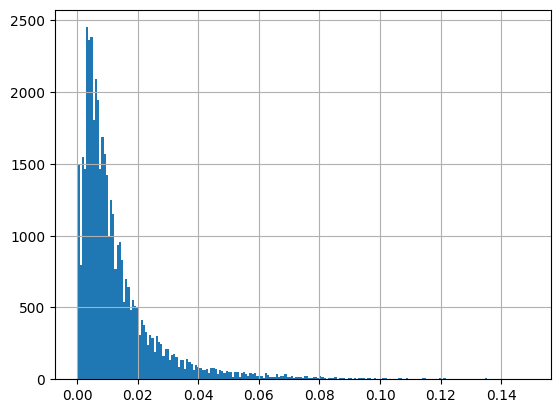

In [54]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
261544,5.94,ug/L,NaN,0.005940000000000001 milligram / liter
266516,1.45,ug/L,NaN,0.00145 milligram / liter
267451,2.77,ug/L,NaN,0.00277 milligram / liter
268302,3.87,ug/L,NaN,0.00387 milligram / liter
276393,8.15,ug/L,NaN,0.008150000000000001 milligram / liter
...,...,...,...,...
1505388,49.06,ug/l,NaN,0.049060000000000006 milligram / liter
1505390,13.4,ug/l,NaN,0.0134 milligram / liter
1505395,10.98,ug/l,NaN,0.01098 milligram / liter
1505396,30.27,ug/l,NaN,0.030270000000000002 milligram / liter


##### Organic Carbon

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(3.8, 'milligram / liter')>
 <Quantity(19.5, 'milligram / liter')>
 <Quantity(11.3, 'milligram / liter')> ...
 <Quantity(4.8, 'milligram / liter')>
 <Quantity(12.9, 'milligram / liter')>
 <Quantity(3.7, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    2.310200e+04
mean     2.299427e+04
std      1.840975e+06
min      0.000000e+00
25%      4.600000e+00
50%      7.100000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1947
Usable results with inferred units: 0
Results outside threshold (0.0 to 11068847.198025672): 8


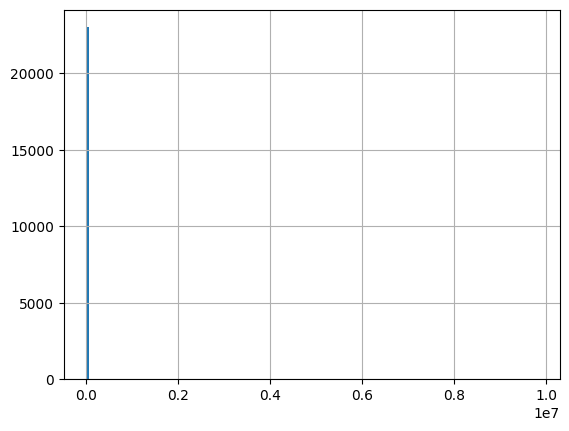

In [56]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
124,19.5,mg/L,NaN,19.5 milligram / liter
125,11.3,mg/L,NaN,11.3 milligram / liter
129,6.7,mg/L,NaN,6.7 milligram / liter
135,28.0,mg/L,NaN,28.0 milligram / liter
...,...,...,...,...
1503658,4.53,mg/l,NaN,4.53 milligram / liter
1503663,1.56,mg/l,NaN,1.56 milligram / liter
1503668,4.8,mg/l,NaN,4.8 milligram / liter
1503673,12.9,mg/l,NaN,12.9 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(4.49, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.2, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.9, 'Nephelometric_Turbidity_Units')> ...
 <Quantity(0.7, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.3, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.1, 'Nephelometric_Turbidity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count     94787.000000
mean         15.857870
std         860.647718
min          -0.047700
25%           1.500000
50%           2.400000
75%           4.000000
max      200000.000000
dtype: float64
Unusable results: 1120
Usable results with inferred units: 0
Results outside threshold (0.0 to 5179.744178874786): 155


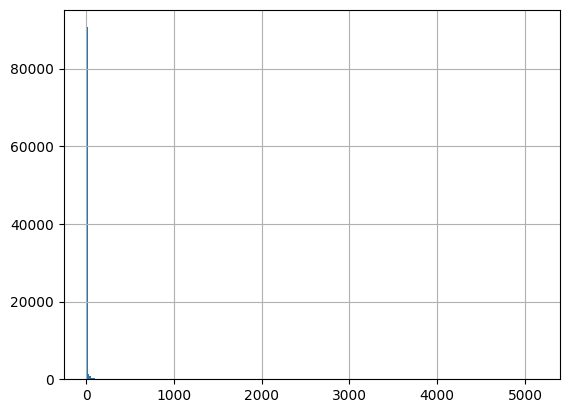

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
21,4.49,NTU,NaN,4.49 Nephelometric_Turbidity_Units
81,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
108,2.9,NTU,NaN,2.9 Nephelometric_Turbidity_Units
148,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
222,4.3,NTU,NaN,4.3 Nephelometric_Turbidity_Units
...,...,...,...,...
1503731,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1503941,0.9,NTRU,NaN,0.9 Nephelometric_Turbidity_Units
1504020,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1504060,2.3,NTRU,NaN,2.3 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.049, 'milligram / liter')>
 <Quantity(0.004, 'milligram / liter')>
 <Quantity(0.049, 'milligram / liter')> ...
 <Quantity(0.04, 'milligram / liter')>
 <Quantity(0.05, 'milligram / liter')>
 <Quantity(0.04, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
19612,0.050,mg/L,NaN,0.05 milligram / liter
...,...,...,...,...
1505721,0.065,mg/l as P,NaN,NaN
1505726,0.027,mg/l as P,NaN,NaN
1505732,0.04,mg/l as P,NaN,NaN
1505747,0.05,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
23731,0.004,mg/L,NaN,NaN
...,...,...,...,...
1505721,0.065,mg/l as P,NaN,NaN
1505726,0.027,mg/l as P,NaN,NaN
1505732,0.04,mg/l as P,NaN,NaN
1505747,0.05,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
19612,0.050,mg/L,NaN,0.05 milligram / liter
29925,0.009,mg/L,NaN,0.009 milligram / liter
56000,0.003,mg/L,NaN,0.003 milligram / liter
65845,0.050,mg/L,NaN,0.05 milligram / liter
70783,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1499474,0.35,mg/l as P,NaN,0.35 milligram / liter
1499477,0.2,mg/l as P,NaN,0.2 milligram / liter
1499482,0.22,mg/l as P,NaN,0.22 milligram / liter
1499505,0.18,mg/l as P,NaN,0.18 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
262349,0.13118375,mg/L,NaN,NaN
279116,0.1696225,mg/L,NaN,NaN
279554,0.0835825,mg/L,NaN,NaN
285845,0.16950375,mg/L,NaN,NaN
295477,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1494655,420.0,mg/kg as P,NaN,NaN
1494995,0.38,%,NaN,NaN
1495004,330.0,mg/kg as P,NaN,NaN
1503040,460.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(300.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(160.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(2.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 56573
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988213): 8


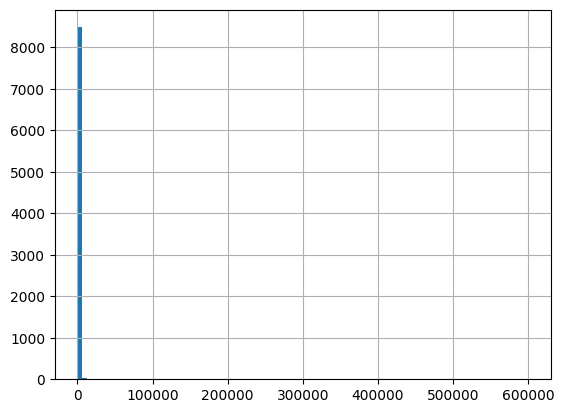

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
13,760,cfu/100mL,NaN,NaN
15,2900,cfu/100mL,NaN,NaN
55,300,#/100mL,NaN,NaN
72,280,#/100mL,NaN,NaN
109,52,cfu/100mL,NaN,NaN
...,...,...,...,...
1501621,100.0,cfu/100ml,NaN,100.0 Colony_Forming_Units / milliliter
1501660,1100.0,cfu/100ml,NaN,1100.0 Colony_Forming_Units / milliliter
1501748,300.0,cfu/100ml,NaN,300.0 Colony_Forming_Units / milliliter
1501802,160.0,cfu/100ml,NaN,160.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(110.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(32.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(20.0, 'Colony_Forming_Units / milliliter')>]' has 

-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 6825
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


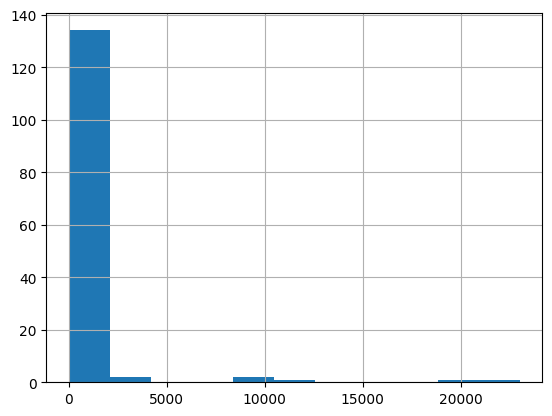

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
218670,210,MPN/100mL,NaN,NaN
220218,4800,MPN/100mL,NaN,NaN
220471,74.5,MPN/100mL,NaN,NaN
220737,553.9,MPN/100mL,NaN,NaN
221299,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1489829,200.0,cfu/100ml,NaN,200.0 Colony_Forming_Units / milliliter
1489934,4.0,cfu/100ml,NaN,4.0 Colony_Forming_Units / milliliter
1489971,110.0,cfu/100ml,NaN,110.0 Colony_Forming_Units / milliliter
1489996,32.0,cfu/100ml,NaN,32.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 274512 
Mean: 21.677560941286323 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
231008,48930,ppth,NaN,48930.0 Practical_Salinity_Units
375380,76.57,ppth,NaN,76.57 Practical_Salinity_Units
438287,54.8,ppth,NaN,54.8 Practical_Salinity_Units
662874,2976,ppth,NaN,2976.0 Practical_Salinity_Units
684335,68,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/harmonize_wq/wrangle.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detection_df = pandas.concat(detection_list).drop_duplicates()


In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25645,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
25646,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46162,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46163,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
508042,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
633203,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
654320,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
795838,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1055106,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1057937,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

422489      626.0 microsiemens / centimeter
426880      688.0 microsiemens / centimeter
444390      606.0 microsiemens / centimeter
445512      606.0 microsiemens / centimeter
448760      633.0 microsiemens / centimeter
522908      776.0 microsiemens / centimeter
525663      776.0 microsiemens / centimeter
526595      775.0 microsiemens / centimeter
528685      776.0 microsiemens / centimeter
531892      775.0 microsiemens / centimeter
878290    20500.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
878290,20500,uS/cm,NaN,NaN,20500.0 microsiemens / centimeter
522908,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
525663,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
528685,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
526595,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
531892,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
426880,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
448760,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
422489,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
444390,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

878290    12.242 dimensionless
522908     0.379 dimensionless
525663     0.379 dimensionless
528685     0.379 dimensionless
526595     0.379 dimensionless
531892     0.379 dimensionless
426880     0.335 dimensionless
448760     0.308 dimensionless
422489     0.304 dimensionless
444390     0.294 dimensionless
445512     0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
878290,2021-09-17,NaN,NaN
522908,2007-08-15,NaN,NaN
525663,2007-08-15,NaN,NaN
528685,2007-08-15,NaN,NaN
526595,2007-08-15,NaN,NaN
...,...,...,...
1509699,1955-04-08,NaN,NaN
1509700,1955-04-08,NaN,NaN
1509701,1957-10-21,14:05:00,EST
1509702,1955-04-08,NaN,NaN


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

,ActivityStartDate,Activity_datetime
878290,2021-09-17,NaT
522908,2007-08-15,NaT
525663,2007-08-15,NaT
528685,2007-08-15,NaT
526595,2007-08-15,NaT
...,...,...
1509699,1955-04-08,NaT
1509700,1955-04-08,NaT
1509701,1957-10-21,1957-10-21 19:05:00+00:00
1509702,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

426880     0.95
448760     0.50
422489     0.00
318451     0.10
319046     0.10
           ... 
1391476    0.33
1444368    0.30
1447791    0.33
1449374    0.33
1449438    0.30
Name: ResultDepthHeightMeasure/MeasureValue, Length: 505, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Other_Phosphorus,QA_Conductivity,QA_Salinity,QA_Carbon,QA_Turbidity,QA_DO,QA_pH,QA_E_coli,QA_Secchi,QA_Chlorophyll
878290,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,2021-09-17,NaN,NaN,NARS_WQX-NWC_FL-10535,STORET-1040690254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522908,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525663,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528685,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145209,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526595,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145207,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509699,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509700,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6842544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509701,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6894410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509702,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6842941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

70566 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Temperature', 'QA_Fecal_Coliform',
       'QA_Nitrogen', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus', 'QA_Conductivity', 'QA_Salinity', 'QA_Carbon',
       'QA_Turbidity', 'QA_DO', 'QA_pH', 'QA_E_coli', 'QA_Secchi',
       'QA_Chlorophyll'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Other_Phosphorus,QA_Conductivity,QA_Salinity,QA_Carbon,QA_Turbidity,QA_DO,QA_pH,QA_E_coli,QA_Secchi,QA_Chlorophyll
878290,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,NARS_WQX-NWC_FL-10535,STORET,NaN,NaN,NaN,NaN,12.242 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522908,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525663,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528685,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526595,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Temperature',
 'QA_Nitrogen',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Conductivity',
 'QA_Salinity',
 'QA_Carbon',
 'QA_Turbidity',
 'QA_DO',
 'QA_E_coli']

<Axes: >

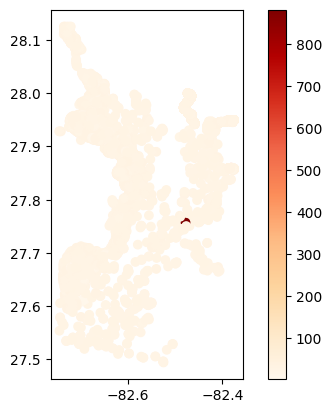

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)